In [60]:
folder_path = '/Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation'
stocks_path = '/Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks'
agents_path = '/Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/agents'

In [61]:
# please print all files in folder_path
import os
print('All files in folder_path:', os.listdir(folder_path))


All files in folder_path: ['trading_agent_master.ipynb', '.DS_Store', 'agents', 'stocks']


# Stock Simulator

In [62]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Define the paths
folder_path = '/Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation'
stocks_path = os.path.join(folder_path, 'stocks')

# 1. Simulate Stock Data
def simulate_stock_data(stock_name, periods, start_date="2025-01-01"):
    """
    Simulates stock data for a given stock name and period.
    Args:
        stock_name (str): Name of the stock.
        periods (int): Number of periods to simulate.
        start_date (str): Start date for the simulation (YYYY-MM-DD).
    Returns:
        pd.DataFrame: Simulated stock data with dates and prices.
    """
    dates = [datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=i) for i in range(periods)]
    prices = [round(100 + np.random.normal(0, 1) * 2, 2) for _ in range(periods)]
    df = pd.DataFrame({"Date": dates, "Price": prices})
    # Save to CSV
    stock_file_path = os.path.join(stocks_path, f"{stock_name}.csv")
    df.to_csv(stock_file_path, index=False)
    print(f"Simulated data for {stock_name} saved to {stock_file_path}")
    return df

# 2. Load and Merge Stock Data
def load_and_merge_stocks():
    """
    Loads all stock CSV files in the 'stocks' folder and merges them into a single DataFrame.
    Returns:
        pd.DataFrame: Merged DataFrame with the first column as dates and subsequent columns as stock prices.
    """
    all_files = [f for f in os.listdir(stocks_path) if f.endswith('.csv')]
    merged_df = pd.DataFrame()
    
    for file in all_files:
        file_path = os.path.join(stocks_path, file)
        stock_name = file.replace('.csv', '')
        df = pd.read_csv(file_path)
        df.rename(columns={"Price": stock_name}, inplace=True)
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on="Date", how="outer")
    
    print("Merged DataFrame created successfully!")
    return merged_df

# Example Usage
# Simulate stocks
# Simulate stocks
if not os.path.exists(stocks_path):
    os.makedirs(stocks_path)

# List of stock symbols to simulate
stock_symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "TSLA", "META", "NVDA", "NFLX", "INTC", "AMD", "BABA", "V"]

# Simulate data for each stock
for stock in stock_symbols:
    simulate_stock_data(stock, 100)  # Simulate 100 days of data for each stock

# Merge simulated stocks
merged_df = load_and_merge_stocks()
print(merged_df.head())  # Display the first few rows of the merged DataFrame

all_stock_data = load_and_merge_stocks()
# print the size of all_stock_data
print('The size of all_stock_data is:', all_stock_data.shape)


Simulated data for AAPL saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/AAPL.csv
Simulated data for GOOG saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/GOOG.csv
Simulated data for MSFT saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/MSFT.csv
Simulated data for AMZN saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/AMZN.csv
Simulated data for TSLA saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/TSLA.csv
Simulated data for META saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/META.csv
Simulated data for NVDA saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/NVDA.csv
Simulated data for NFLX saved to /Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/stocks/NFLX.csv
Simulated data for INTC saved to /Users/

# Agent Simulator

In [63]:
import importlib.util
import os
import pandas as pd
import numpy as np

# Define paths
agents_path = '/Users/james/Desktop/2025 Winter Intersection/trading_agent_simulation/agents'

# Function to load agents
def load_agents():
    """
    Dynamically loads all agent files from the 'agents' folder.
    Returns:
        dict: A dictionary where keys are agent names and values are their modules.
    """
    agents = {}
    for file in os.listdir(agents_path):
        if file.endswith('.py'):
            agent_name = file.replace('.py', '')
            file_path = os.path.join(agents_path, file)
            spec = importlib.util.spec_from_file_location(agent_name, file_path)
            module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(module)
            agents[agent_name] = module
    print(f"Loaded agents: {list(agents.keys())}")
    return agents

# Simulate agent performance
def simulate_agents(all_stock_data, start_cash=10000):
    """
    Simulates trading agents' performance based on their strategies.
    Args:
        all_stock_data (pd.DataFrame): Merged stock data.
        start_cash (float): Initial cash amount for each agent.
    Returns:
        pd.DataFrame: Portfolio values of each agent over time.
    """
    agents = load_agents()
    portfolio_values = {"Date": all_stock_data["Date"].tolist()}
    
    for agent_name, agent_module in agents.items():
        cash = start_cash
        holdings = {stock: 0 for stock in all_stock_data.columns if stock != "Date"}
        portfolio_history = []
        
        for i in range(len(all_stock_data)):
            current_data = all_stock_data.iloc[:i+1]  # Restrict data to the current date
            current_date = current_data.iloc[-1]["Date"]
            
            # Call the agent's decision function
            decisions = agent_module.decide_trades(current_data, cash, holdings)
            
            # Execute trades
            for stock, (action, quantity) in decisions.items():
                if stock not in holdings:
                    continue
                current_price = current_data.iloc[-1][stock]
                if action == "buy":
                    cost = current_price * quantity
                    if cash >= cost:  # Ensure sufficient cash
                        cash -= cost
                        holdings[stock] += quantity
                elif action == "sell":
                    revenue = current_price * quantity
                    if holdings[stock] >= quantity:  # Ensure sufficient stock
                        cash += revenue
                        holdings[stock] -= quantity
            
            # Calculate portfolio value
            stock_value = sum(current_data.iloc[-1][stock] * holdings[stock] for stock in holdings)
            portfolio_value = cash + stock_value
            portfolio_history.append(portfolio_value)
        
        portfolio_values[agent_name] = portfolio_history
    
    return pd.DataFrame(portfolio_values)

# Trading Simulator

In [64]:
# Example usage

start_cash = 100000  # Initial cash amount for each agent

all_stock_data = load_and_merge_stocks()
portfolio_results = simulate_agents(all_stock_data, start_cash)
print(portfolio_results.head())  # Display the first few rows
print(portfolio_results.tail())  # Display the last few rows

Merged DataFrame created successfully!
Loaded agents: ['Test_Agent_1', 'Test_Agent_Cao', 'Test_Agent_3', 'Test_Agent_2']
         Date  Test_Agent_1  Test_Agent_Cao  Test_Agent_3  Test_Agent_2
0  2025-01-01     100000.00       100000.00     100000.00     100000.00
1  2025-01-02     100001.27       100010.61      99996.02     100000.00
2  2025-01-03     100004.90       100006.66     100004.10      99995.33
3  2025-01-04     100013.26        99994.03      99961.53      99979.25
4  2025-01-05     100017.49        99981.89      99949.97      99966.31
          Date  Test_Agent_1  Test_Agent_Cao   Test_Agent_3  Test_Agent_2
95  2025-04-06     100284.49       100169.29  100816.240596      98820.70
96  2025-04-07     100290.50       100001.64  100087.538471      98761.75
97  2025-04-08     100295.69       100053.16  100225.535539      98774.27
98  2025-04-09     100296.97       100041.87   99963.169057      98740.12
99  2025-04-10     100299.40       100080.24  100275.076103      98745.02


In [65]:
# now please first print the rank of each agent based on the final portfolio value
# then print the agent with the highest portfolio value

# Calculate the final portfolio value for each agent
final_portfolio_values = portfolio_results.iloc[-1, 1:]
# Rank the agents based on the final portfolio value
agent_ranking = final_portfolio_values.sort_values(ascending=False)
print("Agent Ranking based on Final Portfolio Value:")
print(agent_ranking)


Agent Ranking based on Final Portfolio Value:
Test_Agent_1           100299.4
Test_Agent_3      100275.076103
Test_Agent_Cao        100080.24
Test_Agent_2           98745.02
Name: 99, dtype: object


# Visulization

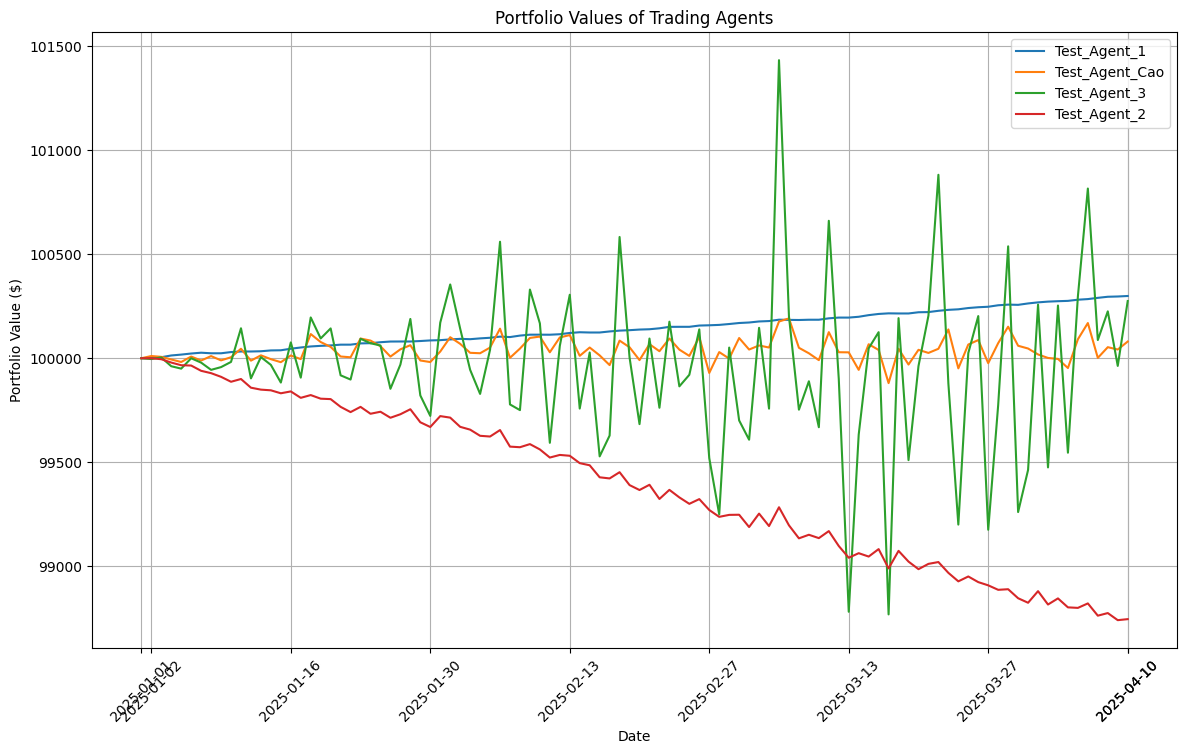

In [67]:
# please make visualization for the portfolio_results, also include agent names in the legend
import matplotlib.pyplot as plt

# Plot the portfolio values for each agent
plt.figure(figsize=(14, 8))
for agent in portfolio_results.columns[1:]:
    plt.plot(portfolio_results["Date"], portfolio_results[agent], label=agent)

# Customize x-axis ticks
dates = portfolio_results["Date"]
num_dates = len(dates)
xticks = [dates.iloc[0]] + [dates.iloc[i] for i in range(1, num_dates, num_dates // 7)] + [dates.iloc[-1]]
plt.xticks(xticks, rotation=45)

plt.title("Portfolio Values of Trading Agents")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.show()


